# Modelagem de nicho ecológico

Esse _notebook_ contém o passo a passo do desenvolvimento do modelo utilizado. O passo a passo está sendo baseado no artigo <span style="color:#2aa2b5">Ecological Modelling 456 (2021) 109671</span>

Objetivos:
- Predição de riqueza de espécies
- Definição de áreas de proteção

## Determinando modelo a ser utilizado
### ENM (Ecological niche modeling)

- Compreende todos os principais algoritmos utilizados em modelos de distribuição de espécies

## Modelo selecionado

O modelo selecionado deve ser o ENM correlativo e híbrido, que utiliza informações geográficas e de ocorrêncas. Esse modelo vai predizer o Nicho realizado (_Realized Niche_) (i.e. A região onde há a intersecção das regiões A, B e M do diagram de Biotic-Abiotic-Movement) (Seção 3)

## Correlative Models

- **Presence-background**
  - Compara as condições de ambiente disponíveis na área de estudo (background) com as condições utilizadas pela espécie de fato. Todas os pontos de background são considerados pontos potencialmente utilizáveis, porém não utilizadas pela espécie. Esse método **não** provém a probabilidade de encontrar a espécie em dada localização, mas um índica de _habitat suitability_, isso é, a qualidade do habitat para a sobrevivência e persistência da espécie, que é específica para cada modelo utilizado.
  
### Modelos:
- Ecological Niche Factor Analysis (ENFA)
- Genetic Algorithm for Rule Set Production (GARP)
- Max entropy (Maxent)


foot_note: Apesar de pontos de background serem comumente atribuidos como equivalente a pontos de pseudo absencia, isso não é verdade. Os pontos de background corresponde a representação de toda a área de estudo.

## Determinando o "alvo" do nicho ecológico que será utilizado para responder a pergunta da questão do estudo

O objetivo do modelo será prever o nicho realizado
Para isso, será utilizado o modelo de **presence-background**

# Modelagem

O passo a passo será

1. Preparação dos dados
2. Cálculo do modelo
3. Avaliação dos modelos
4. Aplicação dos modelos

## Assumptions

Assim como em todo método estatístico, o ENM faz algumas premissas (pg 4)

1. Se a espécie foi observada, então aquele é um local adequado para sua sobrevivência. A espécie ocupa todo habitat adequado onde pode ser dispersado. Por isso, a área de estudo não pode incluir áreas que a espécie não pode dispersar.
2. O viés na modelagem é mínima, porém devem ocorrer por conta de diversas fontes:
   1. Amostragem: Os dados coletados devem conter viés por conta de acessibilidade
   2. Esforço: Os esforços para coleta de dados deve ser diferente ao longo da área de estudo
   3. Variáveis: Inclusão ou exclusão de variáveis que são relevantes ou não pode gerar algum tipo de viés
3. As variáveis incluídas no modelo são relevantes para a ocorrência da espécie, isso é, variáveis que não posseuem variação espacial ou que não possuem relação com a espécie não estão sendo consideradas no modelo
4. A relação entre variáveis ambientais e de ocorrência de espécie são constantes ao longo da área de estudo e de tempo. Quando projetada ao modelo para diferentes cenários, essa consistência deve se assumir que será mantida. Se as espécies se adaptam a novas condições essas relações podem alterar, gerando imprecisões do modelo

# Seleção da área de estudo

Devemos considerar

1. biogeographical regions
2. Evitar áreas em que a espécie não pode habitar

Uma possibilidade é considerar um buffer ao redor dos pontos de ocorrência para determinar uma região em que as espécies podem se dispersar.
Vamos construir um modelo com os pontos de background restringidos a essa condição e outra não restrigida

## Métodos para determinação de background

1. Região considerando mais pontos
2. Região mais restritiva
3. Região levemente mais restritiva

Vamos realizar os testes primeiramente considerando (1)

Ou seja, considerando que toda a região do polígono convexo pode ser habitado pela espécie

# Primeiro Passo:

Preparação dos dados:

- A preparação dos dados está sendo feito nos stages [01 e 02]

O dado de ocorrência gerado é:  ``{DATE}/PREP/occurence.parquet``

In [24]:
import pandas as pd
from sdm_bio.utils import plot_points
import pandas as pd
from sdm_bio.models import plot_roc_curve
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
import json
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
# AIC and BIC (when possible)
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Creating custom functions
def remove_random_background_points(df, num_points_to_remove):
    """
    Remove a specified number of random background points (target = 0) from the dataframe.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe containing the data points with a 'target' column.
    - num_points_to_remove (int): The number of background points to remove.
    
    Returns:
    - pd.DataFrame: The dataframe with the specified number of background points removed.
    """
    # Ensure the DataFrame contains background points
    if df[df['target'] == 0].shape[0] < num_points_to_remove:
        raise ValueError("The number of background points to remove exceeds the available background points.")

    # Get the indices of the background points
    background_indices = df[df['target'] == 0].index
    
    # Randomly sample indices to remove
    indices_to_remove = np.random.choice(background_indices, size=num_points_to_remove, replace=False)
    
    # Drop the selected indices from the DataFrame
    df_dropped = df.drop(indices_to_remove)
    
    return df_dropped

def remove_random_background_points_leave(df, num_points_to_leave):
    """
    Remove a specified number of random background points (target = 0) from the dataframe.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe containing the data points with a 'target' column.
    - num_points_to_remove (int): The number of background points to remove.
    
    Returns:
    - pd.DataFrame: The dataframe with the specified number of background points removed.
    """
    # Ensure the DataFrame contains background points
    
    if df[df['target'] == 0].shape[0] < num_points_to_leave:
        raise ValueError("The number of background points to remove exceeds the available background points.")

    # Get the indices of the background points
    background_indices = df[df['target'] == 0].index
    num_points_to_remove = df[df['target'] == 0].shape[0] - num_points_to_leave
    # Randomly sample indices to remove
    indices_to_remove = np.random.choice(background_indices, size=num_points_to_remove, replace=False)
    
    # Drop the selected indices from the DataFrame
    df_dropped = df.drop(indices_to_remove)
    
    return df_dropped

# Function to create spatial blocks
def create_blocks(gdf, block_size):
    gdf['block_id'] = (gdf.geometry.x // block_size).astype(int) + (gdf.geometry.y // block_size).astype(int) * 10000
    return gdf

# Function to create a buffer around points with TARGET = 1
def create_buffers(gdf, radius_km):
    buffers = gdf[gdf['target'] == 1].copy()
    buffers['geometry'] = buffers.apply(lambda row: row.geometry.buffer(radius_km / 110.574), axis=1)  # Convert km to degrees approx.
    return buffers


## Plot the occurences

target
1    2193
Name: count, dtype: int64

(<Figure size 1000x1200 with 1 Axes>,
 <Axes: title={'center': 'Points on Map'}, xlabel='Longitude', ylabel='Latitude'>)

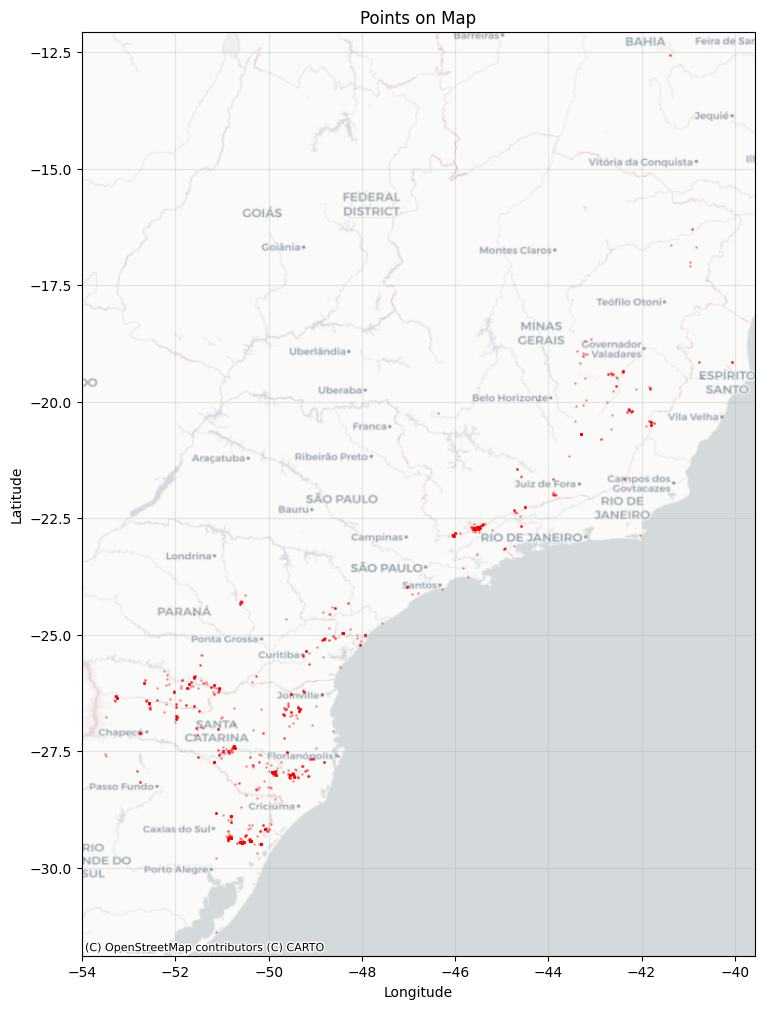

In [3]:
# Occurences default
occurence = pd.read_parquet("../../data/09-06-2024/PREP/occurence.parquet")
display(occurence.target.value_counts())
plot_points(occurence)

## Plot occurences thinned

target
1    353
Name: count, dtype: int64

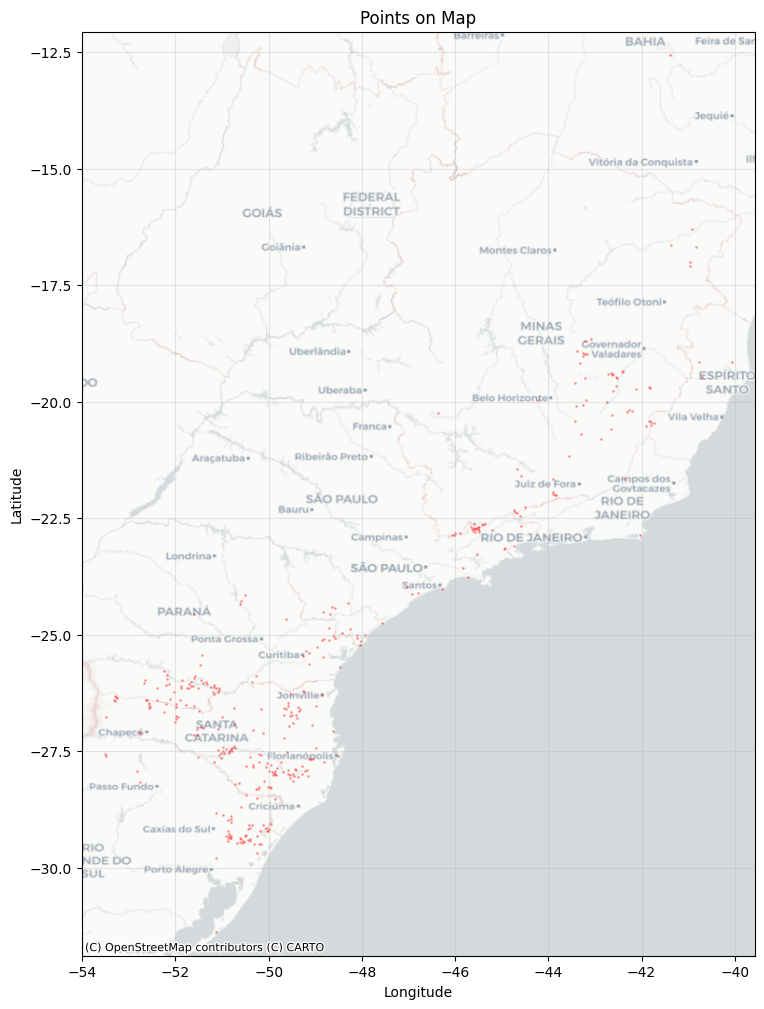

In [49]:
# Occurences thinned
occurence = pd.read_parquet("../../data/09-06-2024/INPUT/occurences_filtered_5000_m.parquet")
plot_points(occurence)
display(occurence.target.value_counts())

Verificando os pontos de background gerados

target
0    9390
1     504
Name: count, dtype: int64

(<Figure size 1000x1200 with 1 Axes>,
 <Axes: title={'center': 'Points on Map'}, xlabel='Longitude', ylabel='Latitude'>)

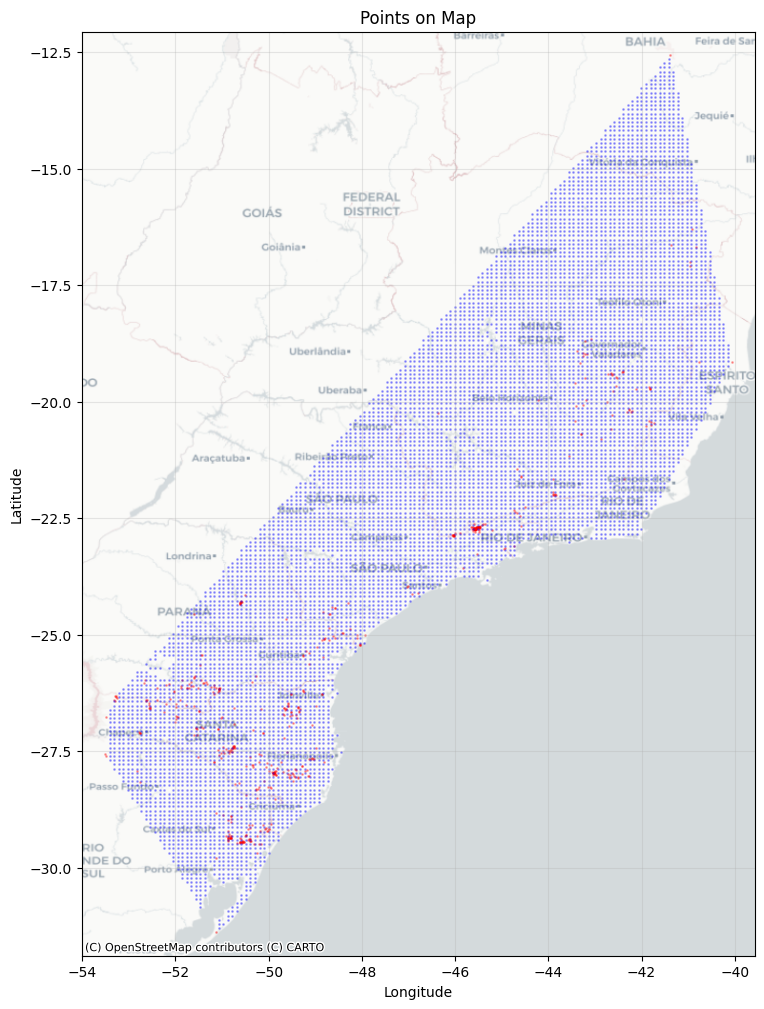

In [6]:
background = pd.read_parquet("../../data/09-06-2024/OUTPUT/features.parquet")
display(background.target.value_counts())
plot_points(background)

Dados somente com as features selecionadas (Que foram consideradas como "essenciais" para a predição)

## Modelos

In [42]:
# Models
def true_skill_statistic(tp, fn, tn, fp):
    """
    Calculate the True Skill Statistic (TSS).

    Parameters:
    - tp (int): True Positives
    - fn (int): False Negatives
    - tn (int): True Negatives
    - fp (int): False Positives

    Returns:
    - float: TSS value
    """
    # Calculate Sensitivity (Recall)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    # Calculate Specificity
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    # Calculate TSS
    tss = sensitivity + specificity - 1
    return tss

def run_model(filtered_df, k, radius_km = 20, create_buffer_points = True, model = LogisticRegression(max_iter=5_000, random_state=42)):
    geometry = [Point(xy) for xy in zip(filtered_df['lon'], filtered_df['lat'])]
    gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)

    # Create buffers
    if create_buffer_points:
        radius_km = radius_km # Define your radius in km
        buffers = create_buffers(gdf, radius_km)

    # Filter out points with TARGET = 0 inside any buffer
    points_0 = gdf[gdf['target'] == 0]
    for buffer in buffers.itertuples():
        points_0 = points_0[~points_0.geometry.within(buffer.geometry)]

    # Merge the remaining points with TARGET = 0 with TARGET = 1 points
    filtered_gdf = pd.concat([gdf[gdf['target'] == 1], points_0])
    gdf = filtered_gdf

    fig, ax = plot_points(filtered_gdf)
    plt.show()
    df_cp = filtered_df.copy()
    y = df_cp.pop("target")
    X = df_cp.copy()
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X,
        y,
        test_size=0.3,  # Test data size
        shuffle=True,  # Shuffle the data before split
        stratify=y,  # Keeping the appearance/non-appearance ratio of Y
    )
    
    # model = LogisticRegression(max_iter=5_000, random_state=42)
    scores = []
    pipe = make_pipeline(StandardScaler(), model)
    if k:  # Cross-validation
        kf = model_selection.KFold(n_splits=100)  # k-fold
        scores = model_selection.cross_val_score(
            pipe, X_train, y_train, cv=kf, scoring="f1_weighted"
        )
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)  # Classifier predictions

    # ROC
    probs = pipe.predict_proba(X_test)
    prob = probs[:, 1]
    fper, tper, thresholds = metrics.roc_curve(y_test, prob)
    # plot_roc_curve(fper, tper, "roc.png")
    _ = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
    plt.show()
    
    aic = None
    bic = None
    if hasattr(pipe, "predict_proba"):
        ll = -log_loss(y_test, probs, normalize=False)
        n_params = len(pipe.coef_.flatten()) if hasattr(pipe, "coef_") else len(X_test.columns)
        aic = 2 * n_params - 2 * ll
        bic = n_params * np.log(len(y_test)) - 2 * ll
    # LOOCV
    # loo = LeaveOneOut()
    # loo_scores = model_selection.cross_val_score(clf, X, y, cv=loo, scoring=scoring)
    # loo_mean_score = loo_scores.mean()
    # Compute confusion matrix
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()

    # Calculate TSS
    tss = true_skill_statistic(tp, fn, tn, fp)
    m_values = {
        "input": {
            "name": "maxent",
            "k_folds": k,
        },
        "output": {
            "cross_validation_mean": float(scores.mean() * 100),
            "cross_validation_err": f"+/- {scores.std() * 200}",
            "accuracy_score": float(metrics.accuracy_score(y_test, y_pred)),
            "AUC_ROC": float(metrics.roc_auc_score(y_test, y_pred)),
            "class_report": str(metrics.classification_report(y_test, y_pred)),
            "confusion_matrix": str(metrics.confusion_matrix(y_test, y_pred).T),
            "probs": [list(i) for i in probs],
            "tss": tss,
            "fper": list(fper),
            "tper": list(tper),
            "AIC": float(aic),
            "BIC": float(bic),
        },
    }
    print(
        f'accuracy_score:{m_values["output"]["accuracy_score"]}',
        f'confusion_matrix:\n{m_values["output"]["confusion_matrix"]}',
        f'cross_validation_mean: {m_values["output"]["cross_validation_mean"]}',
        f'cross_validation_err: {m_values["output"]["cross_validation_err"]}',
        f'class_report:\n{m_values["output"]["class_report"]}'
        f'AUC_ROC: {m_values["output"]["AUC_ROC"]}',
        f'AIC: {m_values["output"]["AIC"]}',
        f'BIC: {m_values["output"]["AIC"]}',
        f'TSS: {m_values["output"]["tss"]}',
        f'y_true: {y_test.value_counts()}',
        sep="\n",
    )
    print("------END------")

In [ ]:
import json

data = pd.read_parquet("../../data/09-06-2024/OUTPUT/data.parquet")
# Contagem de background e ocorrência
data['target'].value_counts()

create_buffer_points = True
df = pd.read_parquet(r"C:\Users\kenji\dev\sdm_bio_vinaceous-breasted-amazon\data\09-06-2024\OUTPUT\features.parquet")
with open(r"C:\Users\kenji\dev\sdm_bio_vinaceous-breasted-amazon\data\09-06-2024\INFO\feat_selection_info.json", "r") as f:
    feat_selection = json.load(f)
df.drop(columns=feat_selection['removed_columns'], inplace=True)


## MAXENT




Number of background points: 9000

Filtered DF: target
0    9000
1     504
Name: count, dtype: int64 



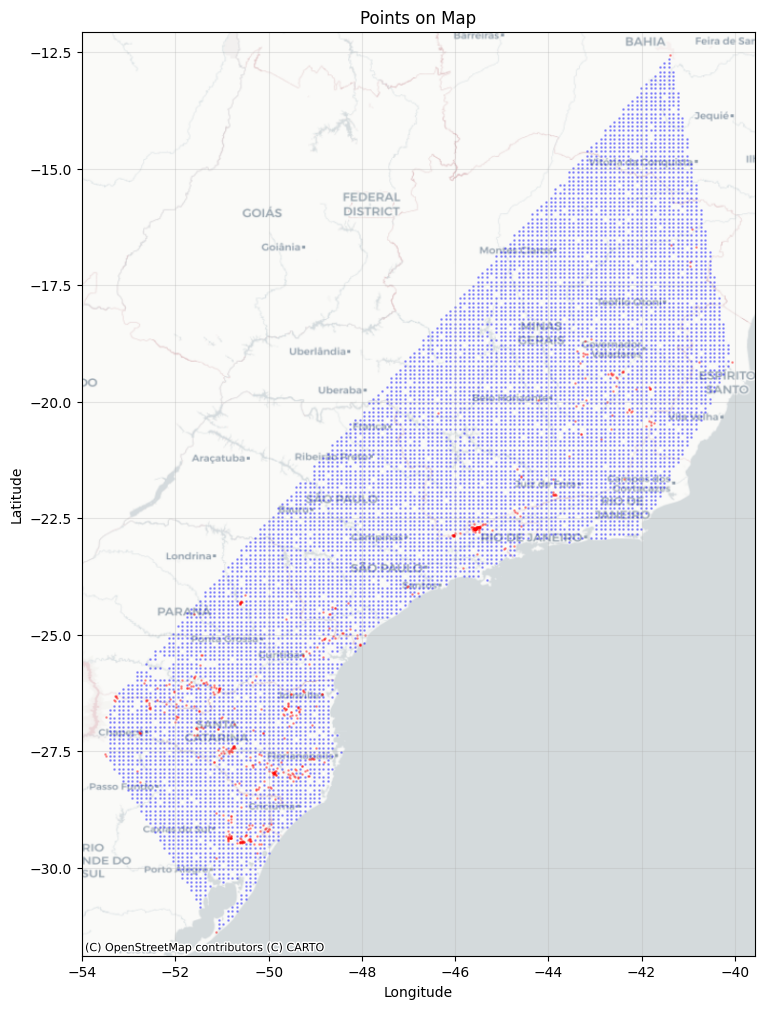

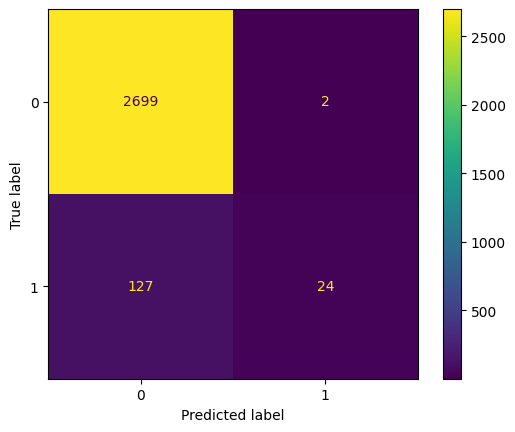

accuracy_score:0.9547685834502104
confusion_matrix:
[[2699  127]
 [   2   24]]
cross_validation_mean: 93.39310630529225
cross_validation_err: +/- 8.021845505379892
class_report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2701
           1       0.92      0.16      0.27       151

    accuracy                           0.95      2852
   macro avg       0.94      0.58      0.62      2852
weighted avg       0.95      0.95      0.94      2852
AUC_ROC: 0.579099965428551
AIC: 869.7205392174889
BIC: 869.7205392174889
TSS: 0.15819993085710227
y_true: target
0    2701
1     151
Name: count, dtype: int64
------END------






Number of background points: 5000

Filtered DF: target
0    5000
1     504
Name: count, dtype: int64 



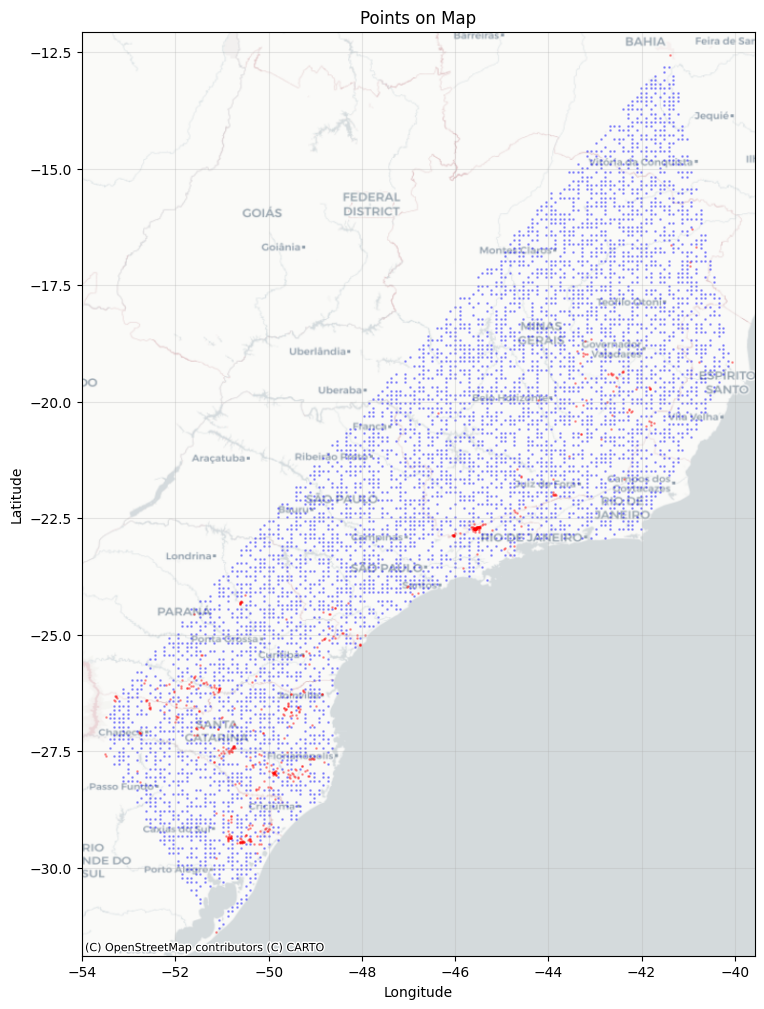

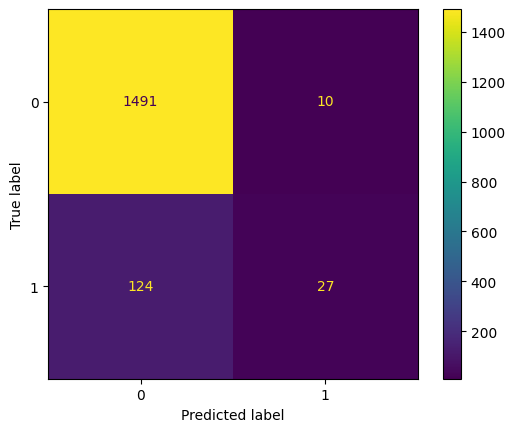

accuracy_score:0.9188861985472155
confusion_matrix:
[[1491  124]
 [  10   27]]
cross_validation_mean: 89.71601579861814
cross_validation_err: +/- 11.530887307685921
class_report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1501
           1       0.73      0.18      0.29       151

    accuracy                           0.92      1652
   macro avg       0.83      0.59      0.62      1652
weighted avg       0.91      0.92      0.90      1652
AUC_ROC: 0.5860728609183281
AIC: 770.9953660958183
BIC: 770.9953660958183
TSS: 0.17214572183665622
y_true: target
0    1501
1     151
Name: count, dtype: int64
------END------






Number of background points: 3000

Filtered DF: target
0    3000
1     504
Name: count, dtype: int64 



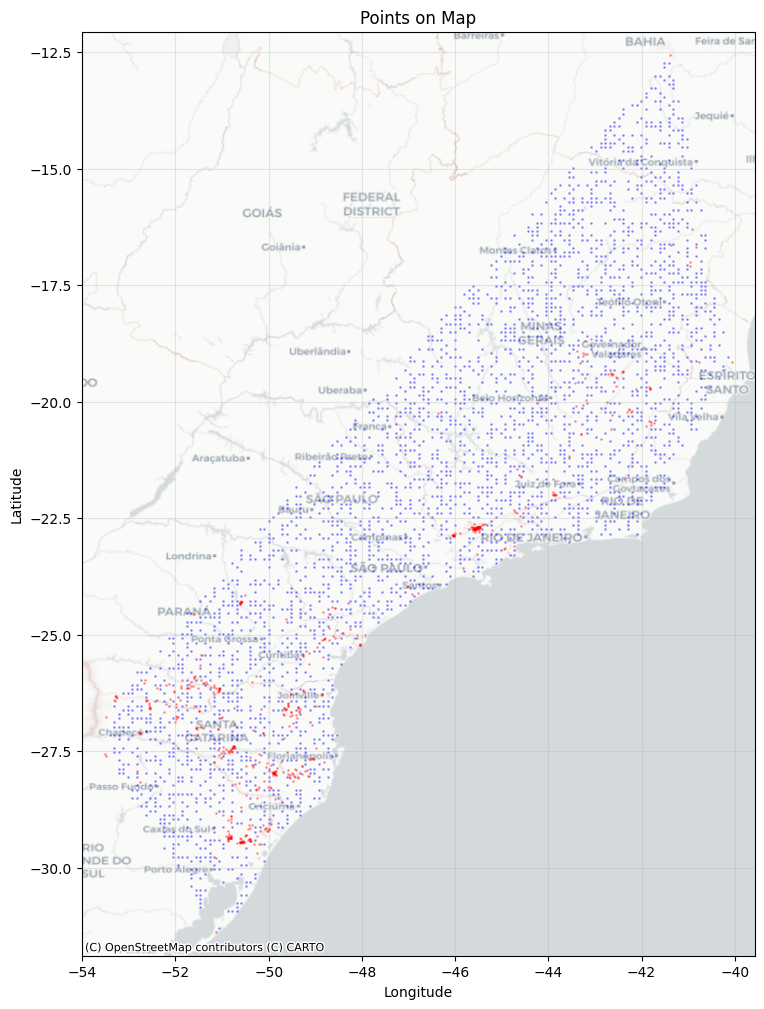

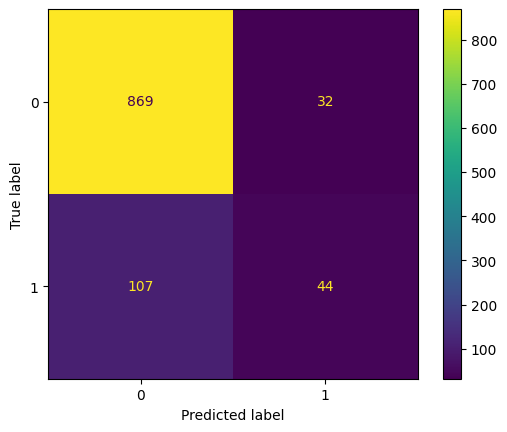

accuracy_score:0.8678707224334601
confusion_matrix:
[[869 107]
 [ 32  44]]
cross_validation_mean: 85.60237012643464
cross_validation_err: +/- 16.062029479964153
class_report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       901
           1       0.58      0.29      0.39       151

    accuracy                           0.87      1052
   macro avg       0.73      0.63      0.66      1052
weighted avg       0.85      0.87      0.85      1052
AUC_ROC: 0.6279373176235382
AIC: 668.7047707785165
BIC: 668.7047707785165
TSS: 0.25587463524707643
y_true: target
0    901
1    151
Name: count, dtype: int64
------END------






Number of background points: 1000

Filtered DF: target
0    1000
1     504
Name: count, dtype: int64 



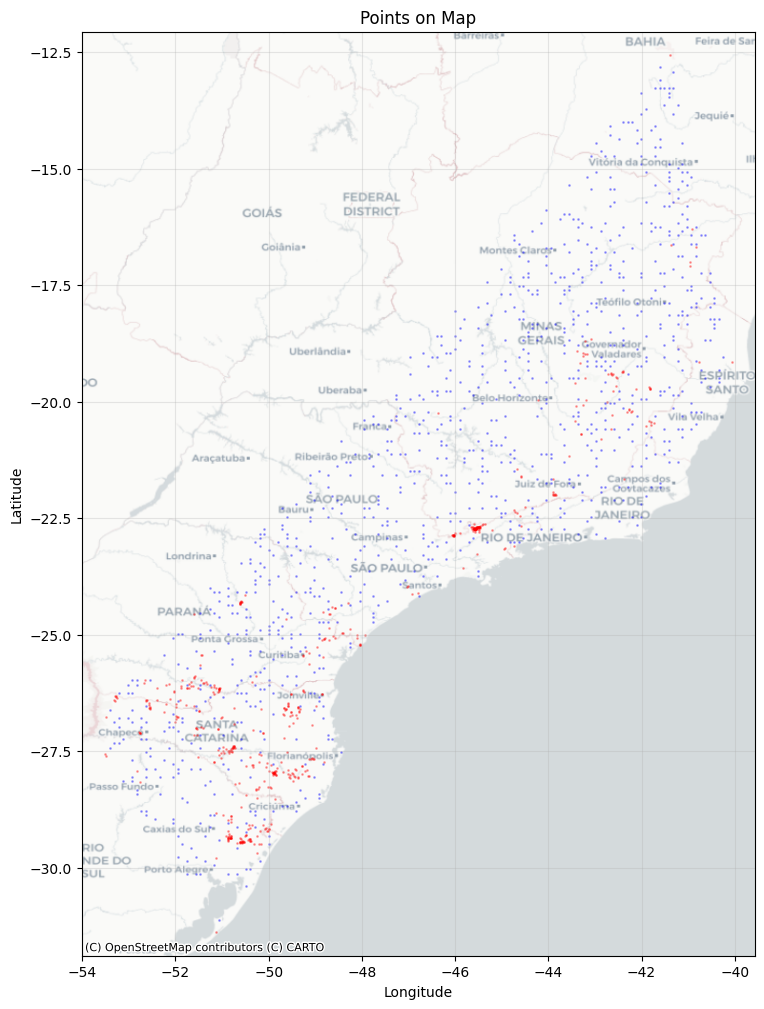

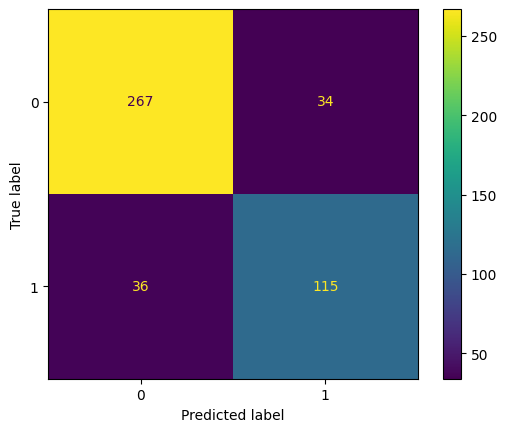

accuracy_score:0.8451327433628318
confusion_matrix:
[[267  36]
 [ 34 115]]
cross_validation_mean: 79.4902576714651
cross_validation_err: +/- 26.00931091992112
class_report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       301
           1       0.77      0.76      0.77       151

    accuracy                           0.85       452
   macro avg       0.83      0.82      0.83       452
weighted avg       0.84      0.85      0.84       452
AUC_ROC: 0.8243162966711404
AIC: 368.18678261131987
BIC: 368.18678261131987
TSS: 0.6486325933422807
y_true: target
0    301
1    151
Name: count, dtype: int64
------END------






Number of background points: 600

Filtered DF: target
0    600
1    504
Name: count, dtype: int64 



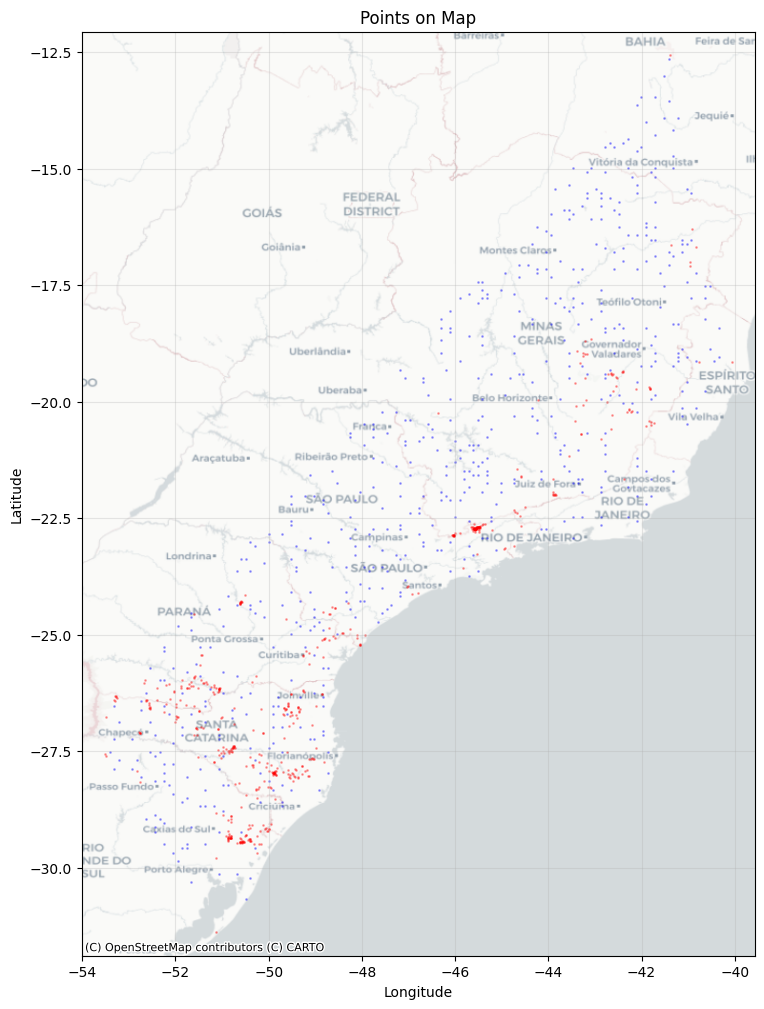

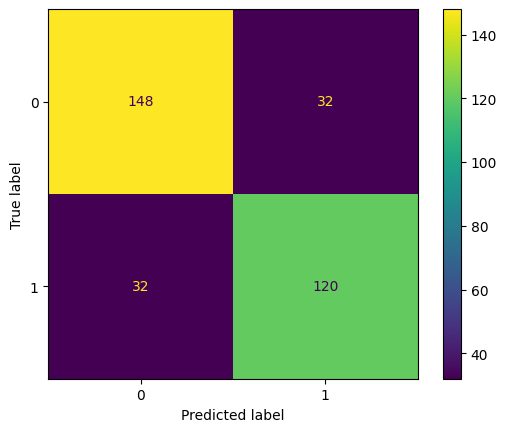

accuracy_score:0.8072289156626506
confusion_matrix:
[[148  32]
 [ 32 120]]
cross_validation_mean: 78.5384781884782
cross_validation_err: +/- 32.38976085855252
class_report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       180
           1       0.79      0.79      0.79       152

    accuracy                           0.81       332
   macro avg       0.81      0.81      0.81       332
weighted avg       0.81      0.81      0.81       332
AUC_ROC: 0.8058479532163743
AIC: 311.73734115288966
BIC: 311.73734115288966
TSS: 0.6116959064327485
y_true: target
0    180
1    152
Name: count, dtype: int64
------END------






Number of background points: 300

Filtered DF: target
1    504
0    300
Name: count, dtype: int64 



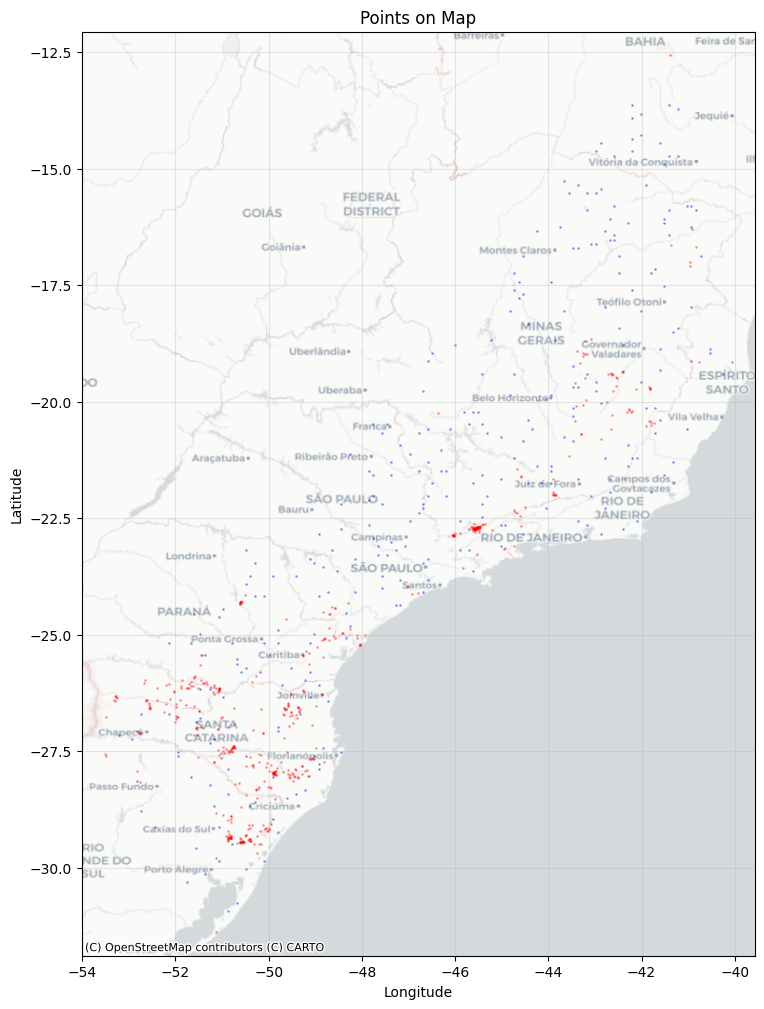

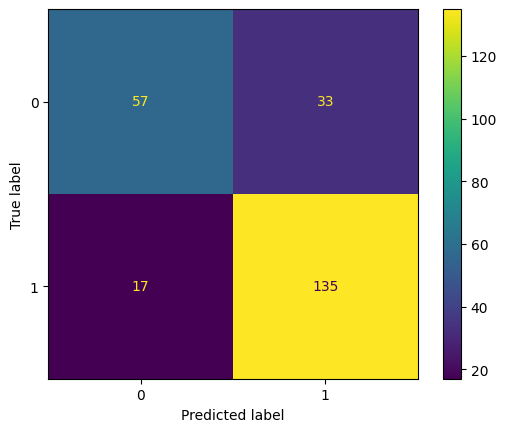

accuracy_score:0.7933884297520661
confusion_matrix:
[[ 57  17]
 [ 33 135]]
cross_validation_mean: 82.83977873977874
cross_validation_err: +/- 28.381306563321
class_report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.70        90
           1       0.80      0.89      0.84       152

    accuracy                           0.79       242
   macro avg       0.79      0.76      0.77       242
weighted avg       0.79      0.79      0.79       242
AUC_ROC: 0.7607456140350877
AIC: 265.02725608223705
BIC: 265.02725608223705
TSS: 0.5214912280701753
y_true: target
1    152
0     90
Name: count, dtype: int64
------END------





In [43]:
k=100
for i in reversed([300, 600 ,1000, 3000, 5000, 9000]):
    print("\n"*2)
    print('========'*4)
    filtered_df = remove_random_background_points_leave(df, i)
    print(f"Number of background points: {i}\n")
    print(f"Filtered DF: {filtered_df.target.value_counts()} \n")
    run_model(filtered_df=filtered_df, k = k, radius_km=5)
    print("\n"*2)
    print('========'*4)

## RANDOM FOREST

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
cls_rf = RandomForestClassifier(n_estimators=100, random_state=42)




Number of background points: 9000

Filtered DF: target
0    9000
1     504
Name: count, dtype: int64 



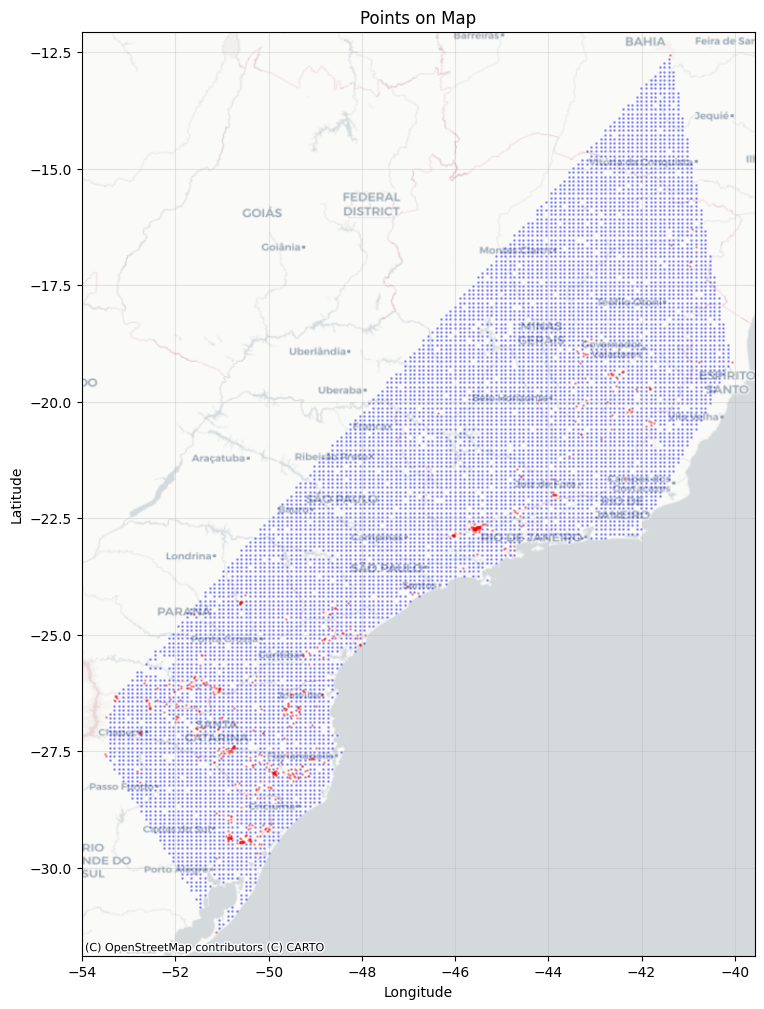

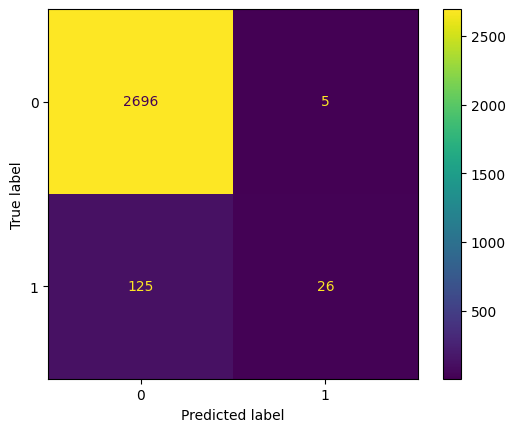

accuracy_score:0.9544179523141655
confusion_matrix:
[[2696  125]
 [   5   26]]
cross_validation_mean: 94.56780326565651
cross_validation_err: +/- 6.973572588884896
class_report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2701
           1       0.84      0.17      0.29       151

    accuracy                           0.95      2852
   macro avg       0.90      0.59      0.63      2852
weighted avg       0.95      0.95      0.94      2852
AUC_ROC: 0.5851671321144242
AIC: 1014.9877498476861
BIC: 1014.9877498476861
TSS: 0.17033426422884812
y_true: target
0    2701
1     151
Name: count, dtype: int64
------END------






Number of background points: 5000

Filtered DF: target
0    5000
1     504
Name: count, dtype: int64 



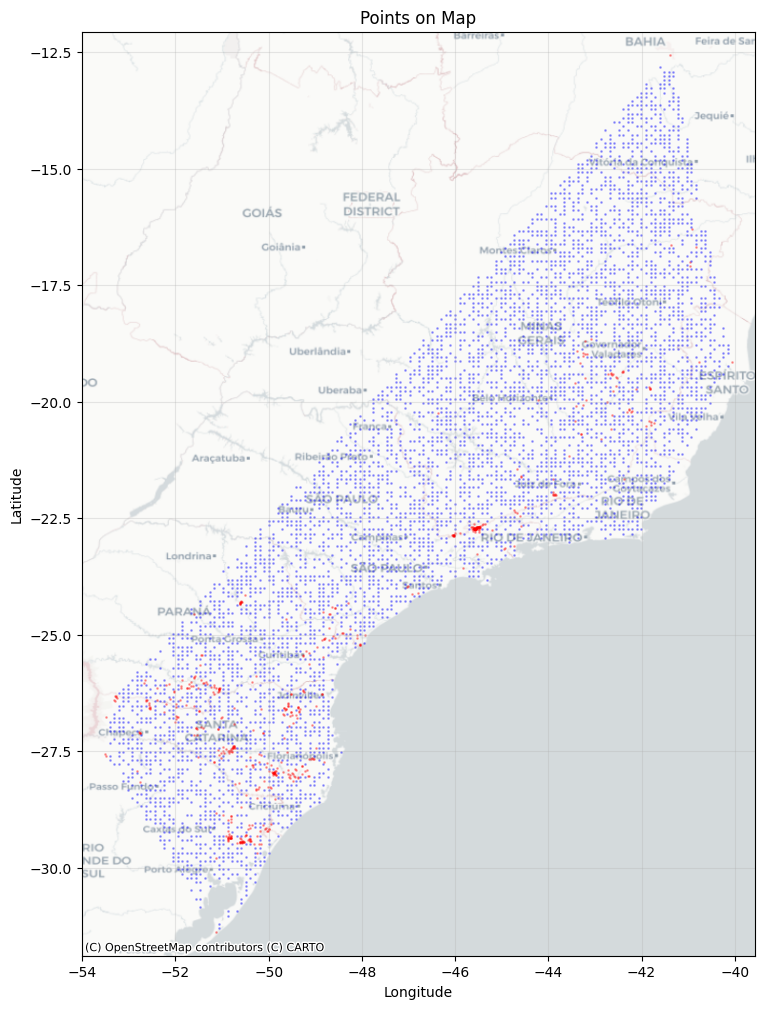

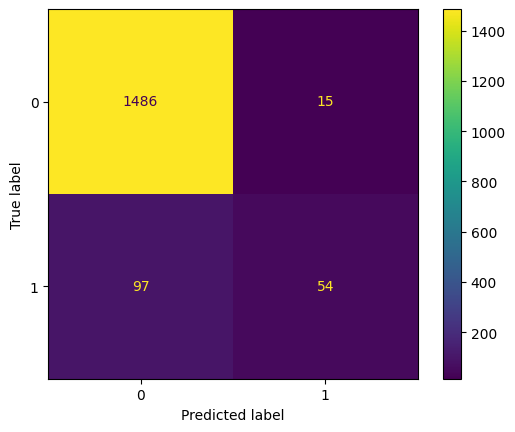

accuracy_score:0.9322033898305084
confusion_matrix:
[[1486   97]
 [  15   54]]
cross_validation_mean: 90.57315163325286
cross_validation_err: +/- 11.471146907219012
class_report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1501
           1       0.78      0.36      0.49       151

    accuracy                           0.93      1652
   macro avg       0.86      0.67      0.73      1652
weighted avg       0.92      0.93      0.92      1652
AUC_ROC: 0.6738112781324591
AIC: 778.0642586784709
BIC: 778.0642586784709
TSS: 0.3476225562649182
y_true: target
0    1501
1     151
Name: count, dtype: int64
------END------






Number of background points: 3000

Filtered DF: target
0    3000
1     504
Name: count, dtype: int64 



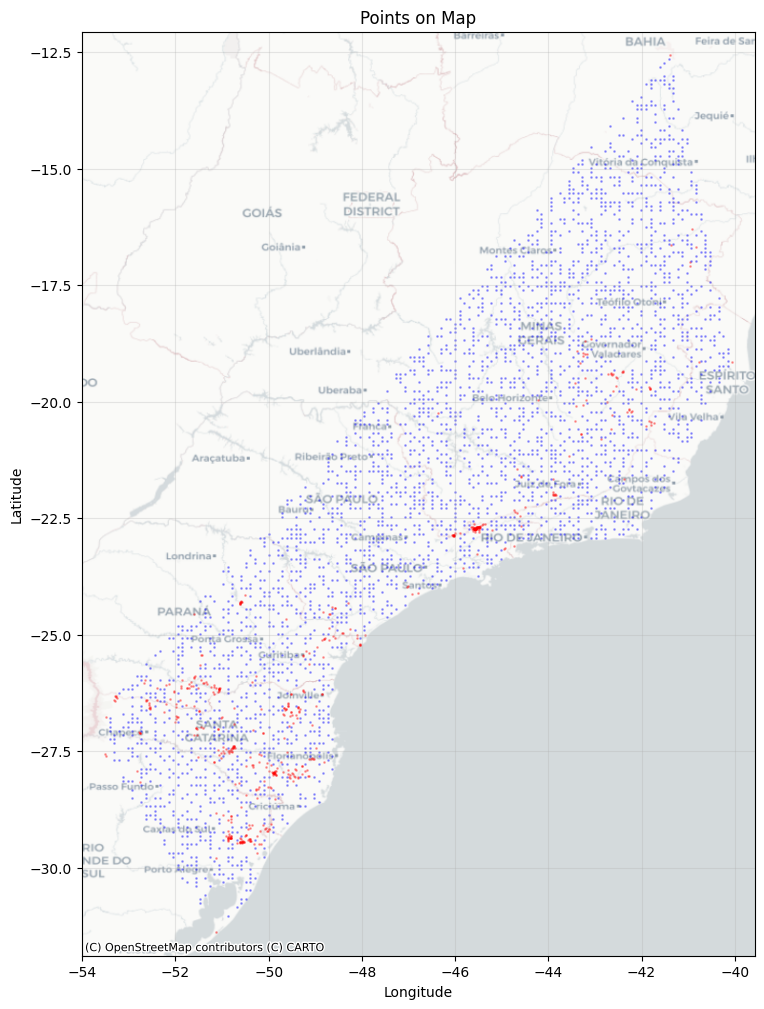

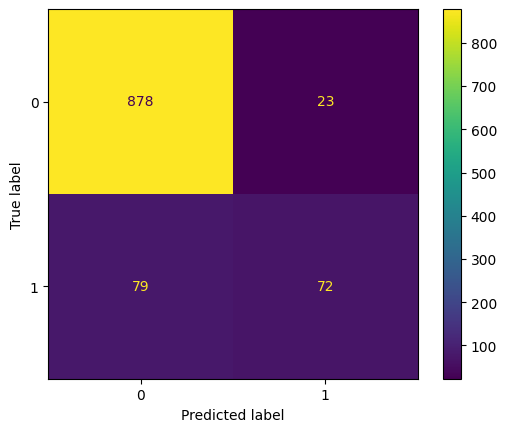

accuracy_score:0.903041825095057
confusion_matrix:
[[878  79]
 [ 23  72]]
cross_validation_mean: 88.05109806139698
cross_validation_err: +/- 15.787955647831097
class_report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       901
           1       0.76      0.48      0.59       151

    accuracy                           0.90      1052
   macro avg       0.84      0.73      0.77      1052
weighted avg       0.89      0.90      0.89      1052
AUC_ROC: 0.7256470000220506
AIC: 631.276302638051
BIC: 631.276302638051
TSS: 0.45129400004410103
y_true: target
0    901
1    151
Name: count, dtype: int64
------END------






Number of background points: 1000

Filtered DF: target
0    1000
1     504
Name: count, dtype: int64 



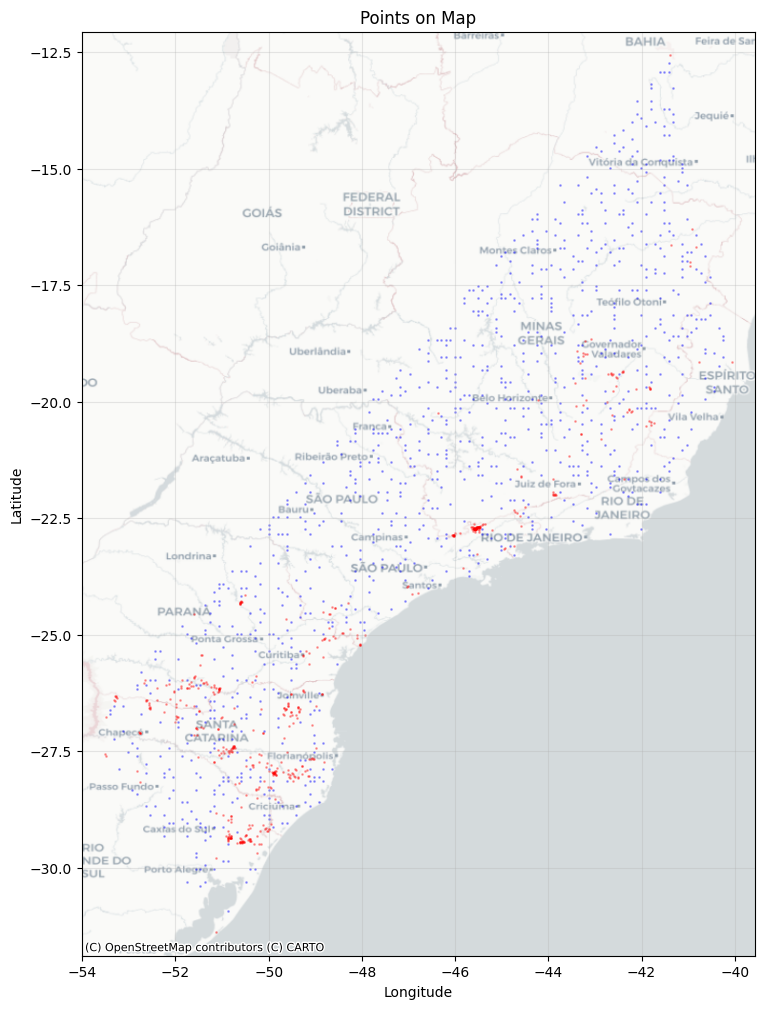

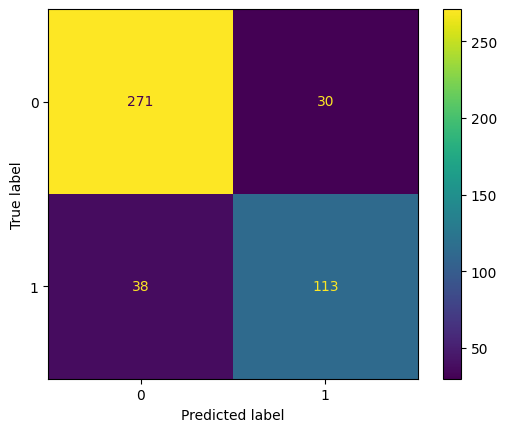

accuracy_score:0.8495575221238938
confusion_matrix:
[[271  38]
 [ 30 113]]
cross_validation_mean: 84.11515458741465
cross_validation_err: +/- 21.62668756117549
class_report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       301
           1       0.79      0.75      0.77       151

    accuracy                           0.85       452
   macro avg       0.83      0.82      0.83       452
weighted avg       0.85      0.85      0.85       452
AUC_ROC: 0.8243382983872742
AIC: 364.37929423597495
BIC: 364.37929423597495
TSS: 0.6486765967745485
y_true: target
0    301
1    151
Name: count, dtype: int64
------END------






Number of background points: 600

Filtered DF: target
0    600
1    504
Name: count, dtype: int64 



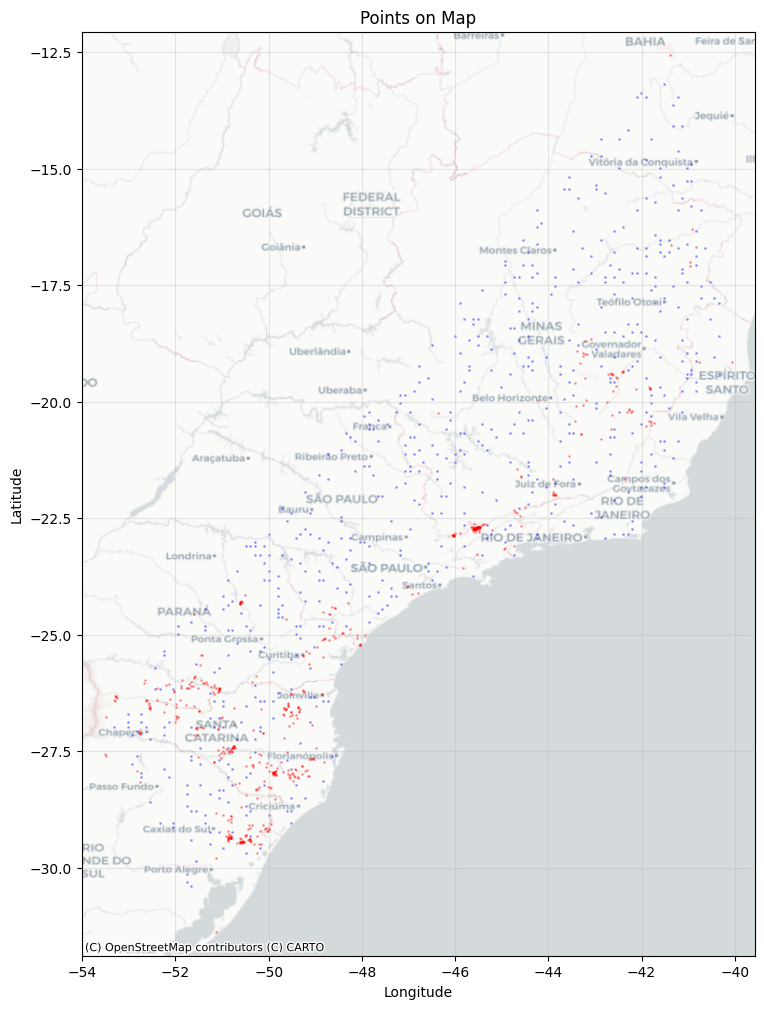

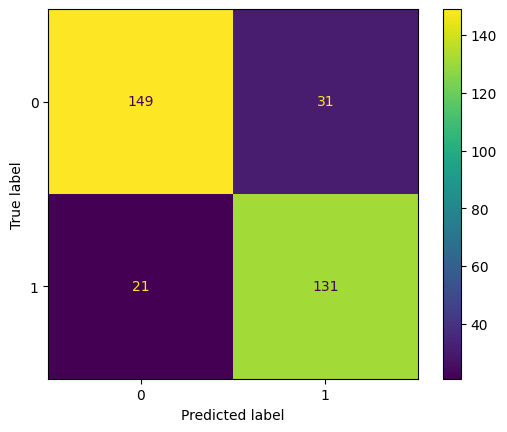

accuracy_score:0.8433734939759037
confusion_matrix:
[[149  21]
 [ 31 131]]
cross_validation_mean: 85.09658674658675
cross_validation_err: +/- 25.74979688073123
class_report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       180
           1       0.81      0.86      0.83       152

    accuracy                           0.84       332
   macro avg       0.84      0.84      0.84       332
weighted avg       0.85      0.84      0.84       332
AUC_ROC: 0.8448099415204677
AIC: 302.7815209272456
BIC: 302.7815209272456
TSS: 0.6896198830409355
y_true: target
0    180
1    152
Name: count, dtype: int64
------END------






Number of background points: 300

Filtered DF: target
1    504
0    300
Name: count, dtype: int64 



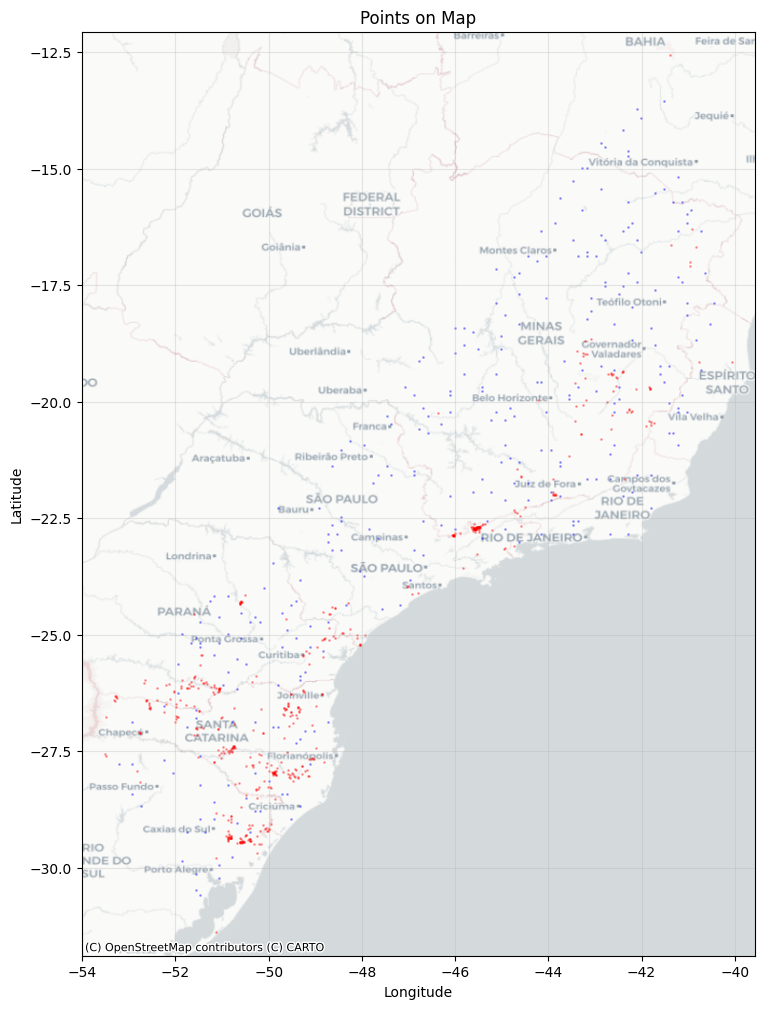

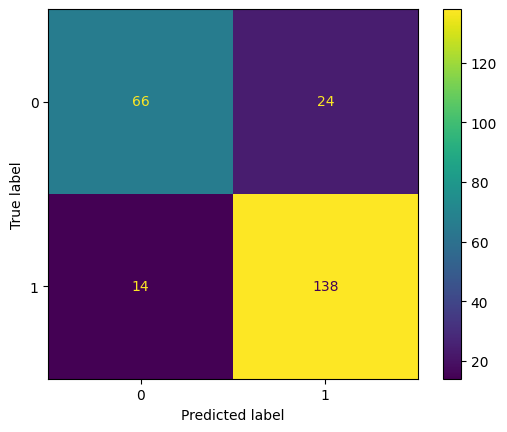

accuracy_score:0.8429752066115702
confusion_matrix:
[[ 66  14]
 [ 24 138]]
cross_validation_mean: 82.86296296296295
cross_validation_err: +/- 32.1694220155238
class_report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.78        90
           1       0.85      0.91      0.88       152

    accuracy                           0.84       242
   macro avg       0.84      0.82      0.83       242
weighted avg       0.84      0.84      0.84       242
AUC_ROC: 0.8206140350877195
AIC: 229.4547101990367
BIC: 229.4547101990367
TSS: 0.6412280701754387
y_true: target
1    152
0     90
Name: count, dtype: int64
------END------





In [46]:
k=100
for i in reversed([300, 600 ,1000, 3000, 5000, 9000]):
    print("\n"*2)
    print('========'*4)
    filtered_df = remove_random_background_points_leave(df, i)
    print(f"Number of background points: {i}\n")
    print(f"Filtered DF: {filtered_df.target.value_counts()} \n")
    run_model(filtered_df=filtered_df, k = k, radius_km=5, model=cls_rf)
    print("\n"*2)
    print('========'*4)